################################################

Owner: Arnab Das

Dataset: ben-eng.txt

##############################################

## Task 5: Attention-based Neural Machine Translation

## Index
> Part A : Bahdanau attention
1. Preprocessing the samples
2. Tokenizing
3. creating the dataset.
4. Defining the encoder.
5. Defining the attention, decoder
6. Defining the training loop and evaluation function
7. Training
8. Testing and plotting the weight distribution
9. Question & answer

> Part B: Dot product attention
1. Defining the attention mechanism
2. Defining the decoder
3. Training
4. Testing and plotting the weight distribution

> Part C: Luong product attention
1. Defining the attention mechanism
2. Defining the decoder
3. Training
4. Testing and plotting the weight distribution
5. Analysis and comparison of three mechanism


In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

### Experiment details:
> For this task of neural machine translation I have choosen the task of Bengali to English translation. 

> The first part of the notebook follows the the tutorial with some changes(mentioned accordingly above relevant cells). And the later part depicts the implementation of other two attention mechanism

In [ ]:
path_to_file ="/content/drive/My Drive/Colab Notebooks/IDL Assignments/ProjectAssignment/Task5/ben-eng/ben.txt"

* As the surce language is bengali, updated the regex
* Purged some lines of code that was not required any more 

In [ ]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFKC', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r'(["।.,!?()])', r' \1 ', w)
  w = re.sub(r'[" "]+', " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [ ]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [ ]:
en, ben, c = create_dataset(path_to_file, None)
print(en[-11])
print(ben[-11])

<start> I can place the palms of my hands on the floor without bending my knees . <end>
<start> আমি হাঁটু ভাজ না করে হাতের পাতা মাটিতে রাখতে পারি । <end>


* Creating word tokens and post padding to match the length of all sequesnce

In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [ ]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang, garbage = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

* Creating train test split

In [ ]:
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file)
# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.05)
# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

4124 4124 218 218


#### Changes:
* The bengali data set is only above 4000 sequence long, which I too less for this task, so had to augment the samples by repeating 3 times

In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)*3//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).repeat(3).shuffle(BUFFER_SIZE*3)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

### Changes:
* As the dataset is small, to increase the capability of the encoder, instead of one layer of GRU, I have used two layers.
* The hidden state and the outcome of the second layer is fed to the attention unit and the decoder(state)

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru_1 = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=False,
                                   recurrent_initializer='glorot_uniform')
    self.gru_2 = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output= self.gru_1(x, initial_state = hidden)
    output, state= self.gru_2(output, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 22]), TensorShape([64, 23]))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 22, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


* Class def for the Bahdanau Attention
## Changes:
* The given tutorail was using the complete sequence lenth to calculate the score and attention weights. This was including the padded input as well. I guess which is not intended, as attenting outcomes of those time steps are not appropriate.
* So i introduced a mask before calculating the softmax attention weights. The mask is computed in two steps,
 1. First a 1/0 mask is introduced with same shape as the actual input to the encode. The one is for the real words and the 0 is for the paaded words in a sequence. 
 2. Next the 0s of the mask is substituted with a very big -ve value  ``` -1e10 ```
 3. Then this mask is eleemnt wise multiplied with the score matrix.
 4. Then the softmax is calculated, So that the softmax put very little probability(close to zero) for those big negative numbers, which is actally the attention wight for the padded words, in a sequence.

 This mask is used for rest two mechanism as well. 


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units, kernel_initializer=tf.keras.initializers.he_uniform)
    self.W2 = tf.keras.layers.Dense(units, kernel_initializer=tf.keras.initializers.he_uniform)
    self.V = tf.keras.layers.Dense(1, kernel_initializer=tf.keras.initializers.he_uniform)

  def call(self, query, values, inp):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    mask = tf.where(tf.not_equal(inp, 0), tf.ones_like(inp), inp)
    mask = tf.cast(tf.expand_dims(mask, -1), dtype=tf.float32)
    reduction= tf.fill(mask.shape, -1e10)
    final_mask = tf.where(tf.equal(mask, 0), reduction, mask)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))
    
    score= score*final_mask

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output, example_input_batch)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 22, 1)


* Decoder class definition

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output, inp):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output, inp)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output, example_input_batch)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 1890)


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output, inp)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.2806
Epoch 1 Batch 100 Loss 1.1103
Epoch 1 Loss 1.1451
Time taken for 1 epoch 55.631274938583374 sec

Epoch 2 Batch 0 Loss 0.8101
Epoch 2 Batch 100 Loss 0.6055
Epoch 2 Loss 0.6874
Time taken for 1 epoch 33.62828850746155 sec

Epoch 3 Batch 0 Loss 0.5740
Epoch 3 Batch 100 Loss 0.4311
Epoch 3 Loss 0.3988
Time taken for 1 epoch 33.13502097129822 sec

Epoch 4 Batch 0 Loss 0.2116
Epoch 4 Batch 100 Loss 0.2054
Epoch 4 Loss 0.2008
Time taken for 1 epoch 34.0141978263855 sec

Epoch 5 Batch 0 Loss 0.1036
Epoch 5 Batch 100 Loss 0.1016
Epoch 5 Loss 0.0969
Time taken for 1 epoch 33.858670234680176 sec

Epoch 6 Batch 0 Loss 0.0701
Epoch 6 Batch 100 Loss 0.0590
Epoch 6 Loss 0.0467
Time taken for 1 epoch 34.2470543384552 sec

Epoch 7 Batch 0 Loss 0.0335
Epoch 7 Batch 100 Loss 0.0309
Epoch 7 Loss 0.0320
Time taken for 1 epoch 33.6471734046936 sec

Epoch 8 Batch 0 Loss 0.0391
Epoch 8 Batch 100 Loss 0.0264
Epoch 8 Loss 0.0239
Time taken for 1 epoch 34.14020133018494 sec

Epoch 9 B

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out, inputs)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

#### Changes:
* The matplotlib axis tickers do not support bengali characters by default. so 'Kalpurush.ttf' is used to get those printed.

In [ ]:
import matplotlib.font_manager as fm
prop = fm.FontProperties(fname='kalpurush.ttf')

### Changes:
* I didn't put the clim in the attention plot, rather i have introduced another mechanism before plotting the attention weight.
* I have normalized the attention matrix by dividing each element of it by the max value of the matrix, so that it automatically comes into a range of [0,1].

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='gray')
  plt.colormaps()

  fontdict = {'fontsize': 14, }

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90, fontproperties=prop)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))
  attention_plot = attention_plot/np.max(attention_plot)

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> টম যখন শুনলো যে মেরি আরে জন বিয়ে করেছে তখন তাকে দেখে বেশ অবাক মনে হয়েছিলো । <end>
Predicted translation: tom seemed quite surprised when he heard that mary and john had gotten married . <end> 


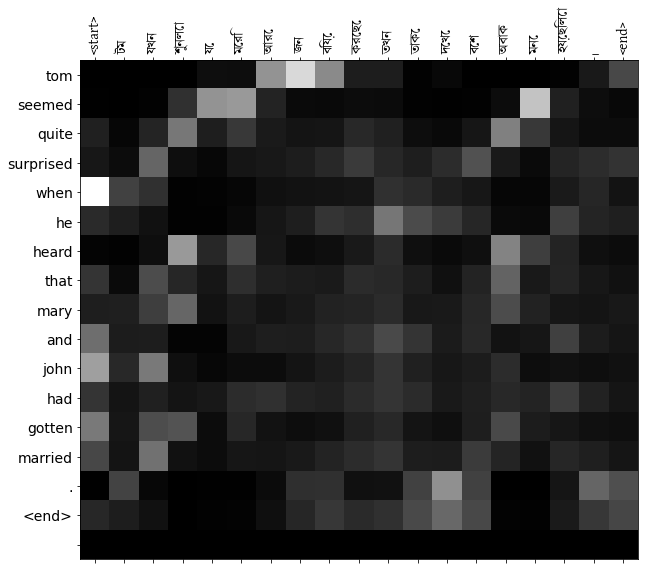

In [ ]:
translate(u'টম যখন শুনলো যে মেরি আরে জন বিয়ে করেছে তখন তাকে দেখে বেশ অবাক মনে হয়েছিলো।')

Input: <start> আমি ফিরে এসেছি । <end>
Predicted translation: i've returned . <end> 


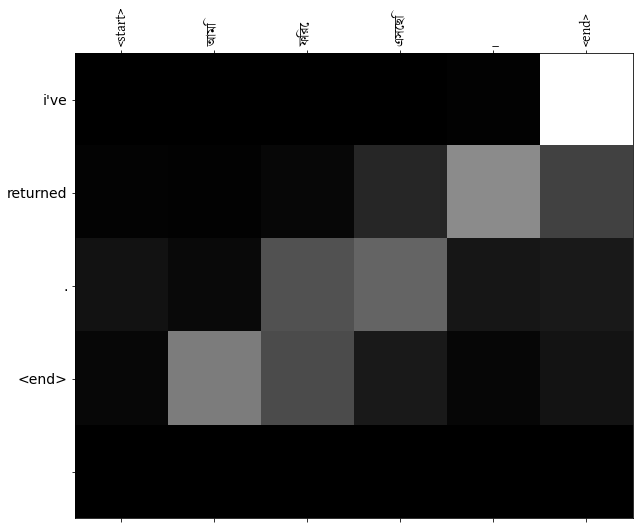

In [ ]:
translate(u'আমি ফিরে এসেছি।')

Input: <start> ওরা আমাদের কী করে ভুলে যেতে পারে ? <end>
Predicted translation: how could they forget us ? <end> 


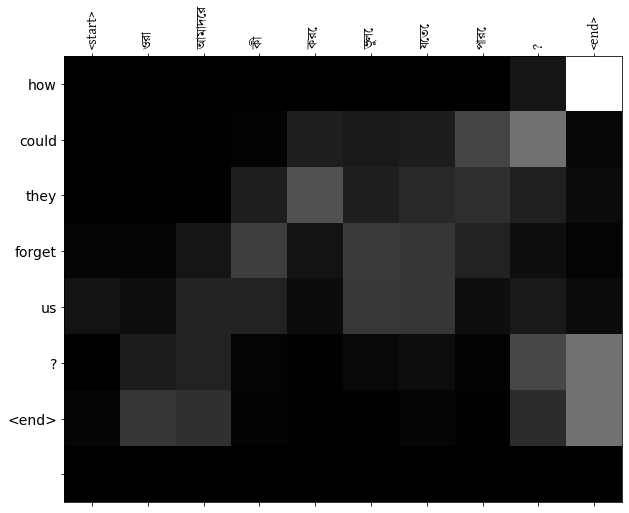

In [ ]:
translate(u'ওরা আমাদের কী করে ভুলে যেতে পারে?')

Input: <start> কয়েক পাতা ইংরাজি অনুবাদ করতে আমার দু ঘন্টারও বেশি সময় লেগেছিলো । <end>
Predicted translation: it took me more than two hours to translate a few pages of english . <end> 


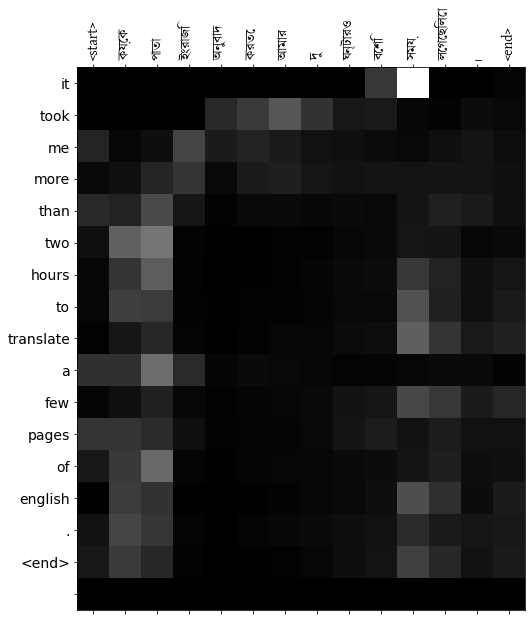

In [ ]:
translate(u'কয়েক পাতা ইংরাজি অনুবাদ করতে আমার দু ঘন্টারও বেশি সময় লেগেছিলো।')

### Question & Answers:
1. **Which parts of the sentence are used as a token? Each character, each word, or are some words split up?**
> Indiviual words, punctuation marks and specially added <start> and <end> are considered as tokens.

2. **Do the same tokens in different language have the same ID?**
> For my task the there is no such chance, as the languages are entirely different. But to answer the question, the answer is no. the id is just a index on the unique language dictionary created from the unique tokens in the language. It doesn't really understand the contextual meang of wrd tokens.

3. **What is the relation between the encoder output and the encoder hidden state which is used to initialize the decoder hidden state?**
> Encoders hidden state is used to initialize decoder hidden state. Encoders output is used as values for calculating attention score.

4. **Is the decoder attending to all previous positions, including the previous decoder predictions?**
> The decoder is not attending the previous positions of decoder. Rather at each time step, it is attending all the time steps of the encoder, by using a softmax distribution of all timestep.
 
5. **Does the Encoder output change in different decoding steps?**
> Encoder output is calculated at once for all time step, and it is not changing for decoder steps.

6. **Does the context vector change in different decoding steps?**
> Yes they do. For each decoder steps the quesry changes, in turns the attention weight distribution and hence the context vector.

7. **The decoder uses teacher forcing. Does this mean the time steps can be computed in parallel?**
> Eavaluation/testing cannot be parallel, it has to stay closed loop. For training could have been parallelized, but for that we had to use the actual targets as input for the decoder time steps, as we already now this actual target outputs for those decoder steps. But one thing this will make the decoder see different input pattern in training and testing, so could be a issue.

8. **Why is a mask applied to the loss function?**
> The target sequence is also post padded with zo to match the max len in target corpora. So we dont want to calculate the loss for padded words. Hence the mask is used.

---

* Class definition for dot product attention.

In [ ]:
class DotAttention(tf.keras.layers.Layer):
  def __init__(self):
    super(DotAttention, self).__init__()

  def call(self, query, values, inp):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    query_with_time_axis = tf.expand_dims(query, -1)

    # score shape == (batch_size, max_length, 1)
    mask = tf.where(tf.not_equal(inp, 0), tf.ones_like(inp), inp)
    mask = tf.cast(tf.expand_dims(mask, -1), dtype=tf.float32)
    reduction= tf.fill(mask.shape, -1e10)
    final_mask = tf.where(tf.equal(mask, 0), reduction, mask)
    score = tf.matmul(values, query_with_time_axis)
    score= score*final_mask

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

* Decoder definition for dot product attention

In [ ]:
class DecoderDot(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(DecoderDot, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = DotAttention()

  def call(self, x, hidden, enc_output, inp):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output, inp)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
encoder = None
decoder = None

* Diiferent checkpoint directory is used to separate models

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = DecoderDot(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
checkpoint_dir = './training_checkpoints_dot'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

* This model with dot product attention is actually trained for 30 epochs(3*10) to get to the desirable accuracy

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.0969
Epoch 1 Batch 100 Loss 0.1023
Epoch 1 Loss 0.1354
Time taken for 1 epoch 23.058599710464478 sec

Epoch 2 Batch 0 Loss 0.1284
Epoch 2 Batch 100 Loss 0.1002
Epoch 2 Loss 0.1299
Time taken for 1 epoch 23.569032430648804 sec

Epoch 3 Batch 0 Loss 0.0753
Epoch 3 Batch 100 Loss 0.1050
Epoch 3 Loss 0.1023
Time taken for 1 epoch 23.24971032142639 sec

Epoch 4 Batch 0 Loss 0.0854
Epoch 4 Batch 100 Loss 0.0787
Epoch 4 Loss 0.0974
Time taken for 1 epoch 23.695663452148438 sec

Epoch 5 Batch 0 Loss 0.1050
Epoch 5 Batch 100 Loss 0.1058
Epoch 5 Loss 0.0876
Time taken for 1 epoch 23.265981197357178 sec

Epoch 6 Batch 0 Loss 0.0884
Epoch 6 Batch 100 Loss 0.1182
Epoch 6 Loss 0.0737
Time taken for 1 epoch 23.837941884994507 sec

Epoch 7 Batch 0 Loss 0.0426
Epoch 7 Batch 100 Loss 0.0337
Epoch 7 Loss 0.0604
Time taken for 1 epoch 23.470617294311523 sec

Epoch 8 Batch 0 Loss 0.0557
Epoch 8 Batch 100 Loss 0.0569
Epoch 8 Loss 0.0561
Time taken for 1 epoch 23.981935024261475 sec

E

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> আমাদের ওখানে নিয়ে চলুন । <end>
Predicted translation: take us there . <end> 


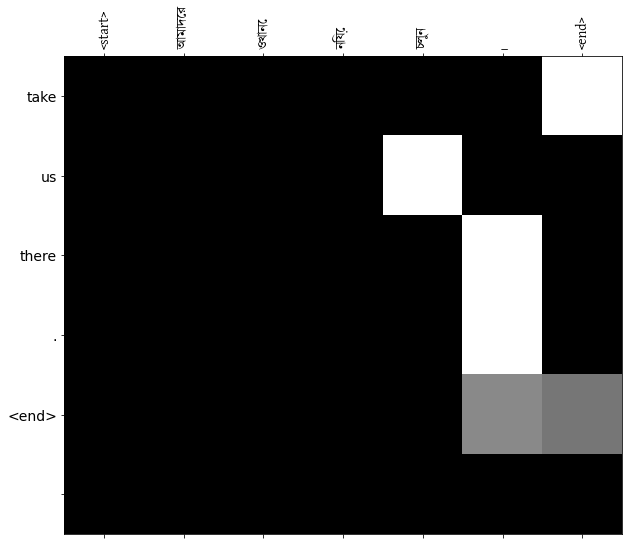

In [ ]:
translate(u'আমাদের ওখানে নিয়ে চলুন।')

Input: <start> আমার একটা মেয়ে আছে । <end>
Predicted translation: i have a daughter . <end> 


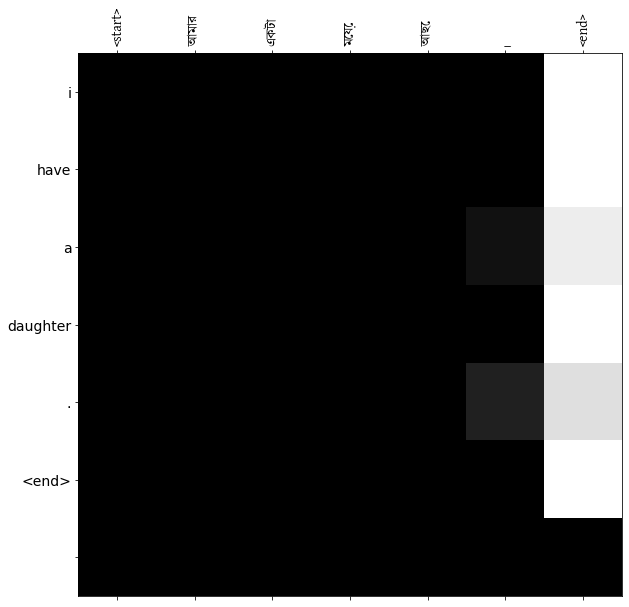

In [ ]:
translate(u'আমার একটা মেয়ে আছে।')

Input: <start> টম এখন লাঞ্চ খেতে চায় । <end>
Predicted translation: tom wants to eat lunch now . <end> 


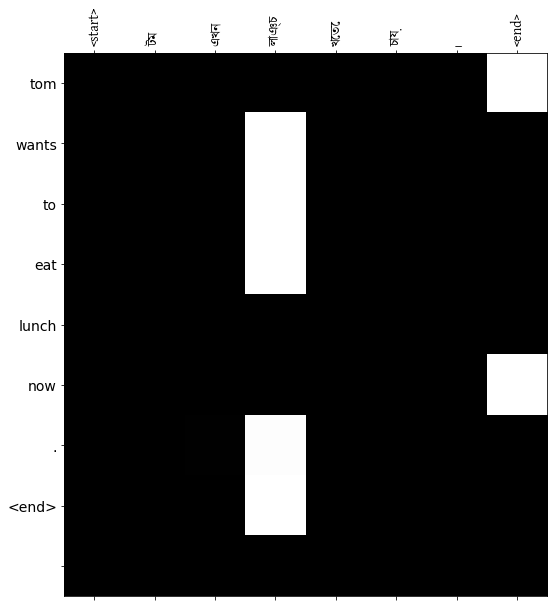

In [ ]:
translate(u'টম এখন লাঞ্চ খেতে চায়।')

Input: <start> এই প্রকল্পটা শেষ হতে আরো অন্তত এক বছর লাগবে । <end>
Predicted translation: this project will take at least a year to finish . <end> 


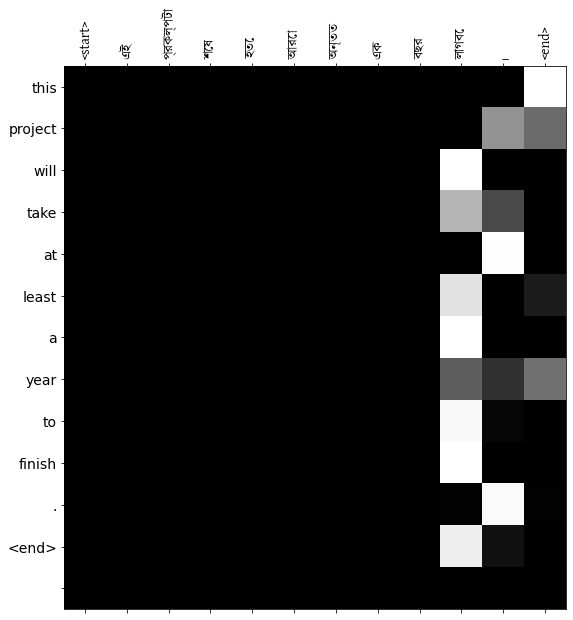

In [ ]:
translate(u'এই প্রকল্পটা শেষ হতে আরো অন্তত এক বছর লাগবে।')

---
* Class definition for Luong attention

In [ ]:
class LuongAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(LuongAttention, self).__init__()
    self.V = tf.keras.layers.Dense(units, kernel_initializer=tf.keras.initializers.he_uniform)

  def call(self, query, values, inp):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    mask = tf.where(tf.not_equal(inp, 0), tf.ones_like(inp), inp)
    mask = tf.cast(tf.expand_dims(mask, -1), dtype=tf.float32)
    reduction= tf.fill(mask.shape, -1e10)
    final_mask = tf.where(tf.equal(mask, 0), reduction, mask)
    score = tf.matmul(values, self.V(query_with_time_axis), transpose_b=True)
    score= score*final_mask

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

* Class definition to decoder with Luong attention

In [ ]:
class DecoderLuong(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(DecoderLuong, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = LuongAttention(dec_units)

  def call(self, x, hidden, enc_output, inp):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output, inp)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
encoder = None
decoder = None

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = DecoderLuong(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
checkpoint_dir = './training_checkpoints_luong'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

* This model is trained for 20 epochs(16+4) to get to the desirable accuracy

In [ ]:
EPOCHS = 4

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.0829
Epoch 1 Batch 100 Loss 0.0724
Epoch 1 Loss 0.0637
Time taken for 1 epoch 23.787955284118652 sec

Epoch 2 Batch 0 Loss 0.0487
Epoch 2 Batch 100 Loss 0.0873
Epoch 2 Loss 0.0738
Time taken for 1 epoch 24.29590082168579 sec

Epoch 3 Batch 0 Loss 0.0522
Epoch 3 Batch 100 Loss 0.0916
Epoch 3 Loss 0.0727
Time taken for 1 epoch 23.871830224990845 sec

Epoch 4 Batch 0 Loss 0.0470
Epoch 4 Batch 100 Loss 0.0529
Epoch 4 Loss 0.0568
Time taken for 1 epoch 24.348707914352417 sec



In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> তুমি কী এনেছো ? <end>
Predicted translation: what have you brought ? <end> 


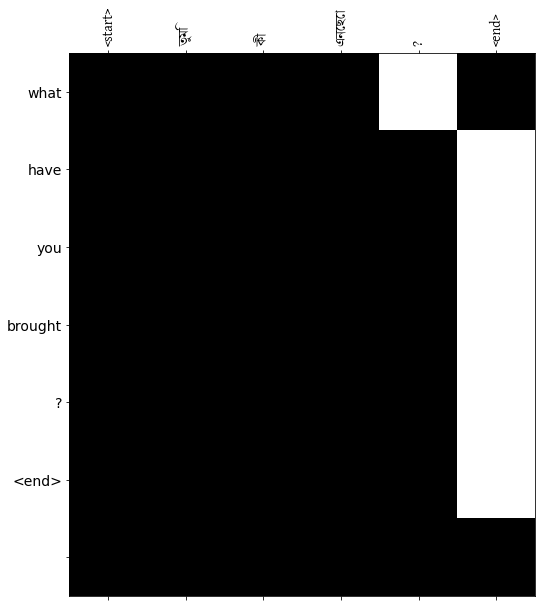

In [ ]:
translate(u'তুমি কী এনেছো?')

Input: <start> আমার হলুদ রঙ পছন্দ । <end>
Predicted translation: i like yellow . <end> 


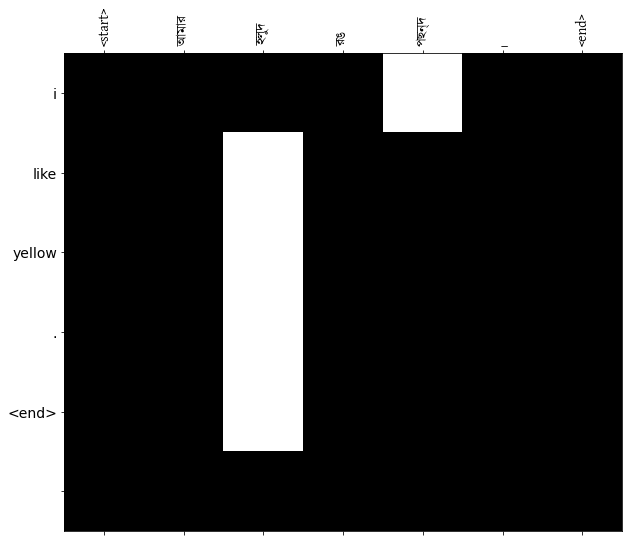

In [ ]:
translate(u'আমার হলুদ রঙ পছন্দ।')

Input: <start> টমকে মারুন । <end>
Predicted translation: hit tom . <end> 


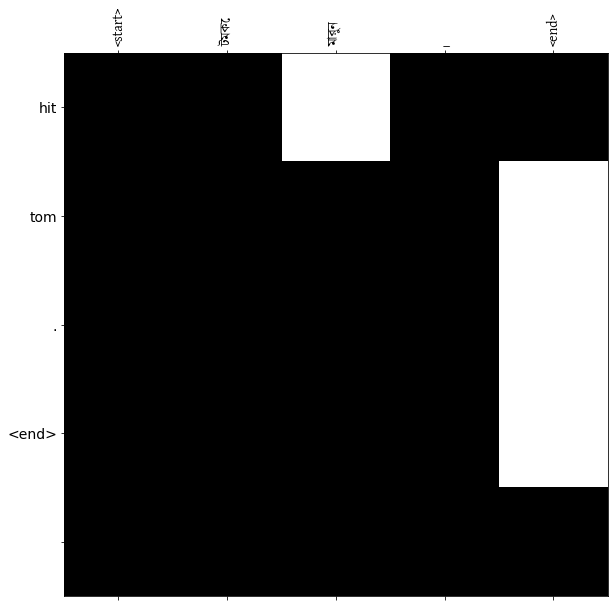

In [ ]:
translate(u'টমকে মারুন।')

## Analysis and comparision:

* **Faster to train**- model with Bahdanau attention is the fastest to train in this experiment settings. It just took 10 epochs to get to the desirable accuracy(translated the test samples perfectly). Whereas it took 20 epochs with Luong attention mechanism and 30 epochs with dot product attention.

* **Qualitative-Attention weights relevance**- The best attention weight distribution is experienced with Bahdanau attention. As I know both the languages, the attention weights are attending correct tokens and even the attention weight is also taking care of contextual tokens, when the sentence structure is complex.  Because the formation is not same in English and Bengali. 

> I will put the Luong attention next. the attention weights sometimes give correct attention, and some times it doesn't, but it is not that bad considering the small amount of training samples. Though all the translations are correct.

> Attention weights plots for the dot product attent is the worst amoung these three. It is putting attention to very wrong tokens. Though it makes most of the translations correct. I am not sure whether it is due to overfitting or not.

* **Weight distribution**- The distribution intensity is also different for theese three. The Bahdanau weight distribution is bit smoother(high varience). So its puts attention to multiple tokens at a time. Where is the attention for Luong attention is the shapest(very narrow varience). It's put a very high attention to just one token at a time. The dot product attention is in the middle in terms of attention weight itensity.

---